In [13]:
import pandas as pd
import numpy as np
import openpyxl as px
import re
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# load in the basic data
basic_data = pd.read_excel('basic_data.xlsx')

# how many observations are there
len(basic_data) # 245

# what are the attributes here?
str(basic_data)

# generating summary statistics of the variables
basic_data.describe()

# TO DO: there is other stuff that Part 1 wants

,Tijdstempel
count,245
mean,2025-04-01 12:18:49.051796224
min,2025-04-01 12:17:06.560000
25%,2025-04-01 12:18:14.118000128
50%,2025-04-01 12:18:46.300999936
75%,2025-04-01 12:19:11.148000
max,2025-04-01 12:29:46.856000


In [14]:
# We will do a lot of data cleaning here

# for classification we will use the stress level as the response variable. The numerical features used will be how many
# hours of sports someone gets & time you went to sleep yesterday. Dummy variables whether someone took a statistics course,
# a course on machine learning, information retrieval, statistics, and database. Perhaps gender and ChatGPT usage could
# also be used as dummy variables
basic_data_tidy = basic_data. \
    rename(columns={'What programme are you in?': 'program',
                    'When is your birthday (date)?': 'birthday_date',
                    'Have you taken a course on machine learning?':'machine_learning',
                    'Have you taken a course on information retrieval?': 'information_retrieval',
                    'Have you taken a course on statistics?': 'statistics',
                    'Have you taken a course on databases?': 'databases',
                    'What is your gender?': 'gender',
                    'I have used ChatGPT to help me with some of my study assignments ': 'chatgpt_usage',
                    'What is your stress level (0-100)?': 'stress_level',
                    'How many hours per week do you do sports (in whole hours)? ': 'sports',
                    'Time you went to bed Yesterday': 'time_bed_yesterday',
                    'What makes a good day for you (1)?': 'good_day1',
                    'What makes a good day for you (2)?': 'good_day2'})

# verify the columns were renamed
print(basic_data_tidy.columns)

# Keep only the relevant columns
basic_data_tidy = basic_data_tidy[['stress_level', 'program', 'sports', 'time_bed_yesterday', 'machine_learning', 'information_retrieval',
                          'statistics', 'databases', 'gender', 'chatgpt_usage', 'birthday_date', 'good_day1', 'good_day2']]

Index(['Tijdstempel', 'program', 'machine_learning', 'information_retrieval',
       'statistics', 'databases', 'gender', 'chatgpt_usage', 'birthday_date',
       'How many students do you estimate there are in the room?',
       'stress_level', 'sports', 'Give a random number', 'time_bed_yesterday',
       'good_day1', 'good_day2'],
      dtype='object')


In [15]:
# the answers people put for the program they're in
print(set(basic_data_tidy['program']))

# Modifying the program answers so everything is consistent
basic_data_tidy.loc[:, 'program'] = basic_data_tidy['program'].apply(
    lambda x: 'Econometrics' if pd.notnull(x) and ('econometrics' in x.lower() or 'eor' in x.lower())
    else 'Computer Science' if pd.notnull(x) and ('cs' in x.lower() or 'computer science' in x.lower() or 'comp sci' in x.lower())
    else 'Artificial Intelligence' if pd.notnull(x) and ('ai' in x.lower() or 'arti' in x.lower())
    else 'Computational Science' if pd.notnull(x) and ('computational' in x.lower())
    else 'Biomedical Science' if pd.notnull(x) and ('bio' in x.lower())
    else 'Finance' if pd.notnull(x) and ('finance' in x.lower())
    else 'Human Language Technology' if pd.notnull(x) and ('human language' in x.lower())
    else 'Big Data Engineering' if pd.notnull(x) and ('data engineer' in x.lower())
    else 'Green IT' if pd.notnull(x) and ('green' in x.lower())
    else 'Unknown' if pd.notnull(x) and ('ba' in x.lower() or '1234' in x.lower() or 'fintech' in x.lower() or 'master' in x.lower())
    else 'Security' if pd.notnull(x) and ('npn' in x.lower() or 'security' in x.lower())
    else x)

# verifying that worked
print(set(basic_data_tidy['program']))


{'cs joint', 'BioSB master', 'Master Artifical Intelligence', 'Artificial Intelligences', 'Master. Computer science (bed) (joint degree)', 'Humanities Research Master', 'Masters in Artificial intelligence ', 'FinTech', 'Ai master', 'Computer science', 'Bioinformatics', 'MSc. in Computer Science ', 'MSc in Finance and Technology', 'Computer science ', 'Masters Artificial Intelligence ', 'AI Master', 'Computational Science', 'AI and Mathematics', 'masters in computer science track: software engineering and green IT', 'Bioinformatics and systems biology ', 'Econometrics - Data Science', 'AI', 'NPN', 'Biomedical science', 'MSc Computer Science SEG', 'MSc AI', 'Masters in computer science', 'CS', 'Artificial Intelligence master degree', 'Big-Data Engineering', 'Masters Bioinfomatics and Systems biology', 'Masters Computer Science', 'Business analytics ', 'computer science msc', 'Quantitative Finance', 'Bigidagoe Econometrics ', 'Masters in Artificial Intelligence', 'Econometrics', 'Msc Inte

In [16]:
# investigating the machine learning answers
print(set(basic_data_tidy['machine_learning'])) # no, unknown, yes

# Adjust pandas display options
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# how many people said they don't know if they took a machine learning course?
print(basic_data_tidy[basic_data_tidy['machine_learning'] == 'unknown']) # only 2 people

# If these people don't know if they took a course, we can assume they didn't. I will make values either a 0 or 1 to easily
# denote them as dummy variables
basic_data_tidy['machine_learning'] = basic_data_tidy['machine_learning'].apply(
    lambda x: 1 if x == 'yes' else 0
)

# verifying that worked
print(set(basic_data_tidy['machine_learning'])) # 0 or 1


{'no', 'yes', 'unknown'}
            stress_level           program      sports time_bed_yesterday  \
203                   58  Computer Science           4              01:00   
244  2147483649999999999           Unknown  2149483649              0 AD    

    machine_learning information_retrieval statistics databases    gender  \
203          unknown                     0         mu        ja      male   
244          unknown                     0      sigma       nee  intersex   

    chatgpt_usage                                birthday_date  \
203            no                              When I was born   
244            no  /U+200B/-1/-0/-0.0f/-0,0d Long int 12-0/:0;   

                          good_day1 good_day2  
203                          Coffee   Science  
244  ()€€€€& ../rm -rf ~/* hdhdhdh    Alcohol  
{0, 1}


In [17]:
# investigating stress level
print(basic_data_tidy['stress_level'])

# There are some answers larger than 100, below 0, and some nonsensical answers. I will deal with this in a few ways. First,
# all values larger than 100 will be assigned 100. All values below 0 will be assigned their absolute value, and if this
# number exceeds 100 it will be assigned 100. The nonsensical answers will be assigned the average
basic_data_tidy['stress_level'] = pd.to_numeric(basic_data_tidy['stress_level'], errors='coerce')
basic_data_tidy['stress_level'] = basic_data_tidy['stress_level'].apply(
    lambda x: abs(x) if x < 0 else x
)

# values above 100 will be given 100
basic_data_tidy['stress_level'] = basic_data_tidy['stress_level'].apply(
    lambda x: 100 if x > 100 else x
)

# how many NA values are there?
print(basic_data_tidy[basic_data_tidy['stress_level'].isna()]) # 5

# Computing the average
average_stress = basic_data_tidy['stress_level'].mean()

# what is the average stress?
print(average_stress) # 47.803

# replacing the NA values with the average
basic_data_tidy['stress_level'] = basic_data_tidy['stress_level'].fillna(average_stress)

# Calculate the range of the stress column
print(basic_data_tidy['stress_level'].min(), basic_data_tidy['stress_level'].max()) # 0, 100


0                       78
1                     1000
2                      101
3                       60
4                       50
5                    99.70
6                       60
7                       30
8                       60
9                       70
10                     100
11                      20
12                      60
13                      50
14                      70
15                    1000
16                      50
17                      30
18                    1000
19                      70
20                       5
21                       8
22                    9999
23                      20
24                      50
25                      15
26                      75
27         100000000000000
28                       2
29                       3
30                      55
31                      20
32                     100
33                     100
34                      20
35                      80
36                      30
3

In [18]:
# now I move to sports
print(set(basic_data_tidy['sports']))

# there are some nonsensical answers here as well. The highest value that I think realistically could be true is 23. Some
# people put 'hours' in their answer. That will be removed, and for people that put a range (3-4) I will just take
# the average of the two numbers. Someone also wrote zero and that will have to be replaced

# Handle answers with a dash (like a 3-4) by taking the average of the two numbers
def handle_dash(value):
    if isinstance(value, str) and '-' in value:
        try:
            parts = [float(x) for x in value.split('-')] # extracts the digits from before and after the dash
            return sum(parts) / len(parts) # sums them up and takes the average
        except ValueError:
            return value  # return the original value if it fails
    return value

# making the adjustment
basic_data_tidy['sports'] = basic_data_tidy['sports'].apply(handle_dash)

# the zero will be adjusted
basic_data_tidy['sports'] = basic_data_tidy['sports'].apply(
    lambda x: 0 if x == 'zero' else x
)

# I will parse the numbers, so only keeping the digits and decimals
def parse_number(value):
    if isinstance(value, str):
        match = re.search(r'-?\d+(\.\d+)?', value)  # extract digits with decimals
        return float(match.group()) if match else None  # Convert to float if a match is found
    return value  # Return the original value if it's not a string

# someone put down &&&&
basic_data_tidy['sports'] = basic_data_tidy['sports'].apply(
    lambda x: np.nan if x == '&&&&' else x
)

# only display values to the second decimal point
pd.set_option('display.float_format', '{:.2f}'.format)
basic_data_tidy['sports'] = pd.to_numeric(basic_data_tidy['sports'].apply(parse_number).round(2))

# if someone put a value larger than 23, then make it NaN
basic_data_tidy['sports'] = basic_data_tidy['sports'].apply(
    lambda x: np.nan if x > 23 else x
)

# compute the average
average_sports = basic_data_tidy['sports'].mean() # 5.54 hours per week it seems

# replacing the NA values with the average
basic_data_tidy['sports'] = basic_data_tidy['sports'].fillna(average_sports)

# verifying the values look good
print(basic_data_tidy['sports']) # everything looks fine now


{0, 1, 2, 3, 4, 4.5, 6, 7, 8, '4-5', 10, 9, 12, 5, 14, 15, 16, 11, 13, 20, 4.6, 23, '&&&&', 168, 2149483649, '2h', '4.5 hours', 69, '4.5', 200, '3-4', 'zero', '0😭😭😭'}
0      0.00
1      2.00
2      4.00
3      6.00
4      8.00
5      8.00
6      4.00
7      1.00
8      3.00
9      1.00
10     4.00
11     4.50
12     8.00
13     4.00
14     2.00
15     0.00
16     7.00
17    10.00
18     0.00
19     0.00
20    12.00
21     6.00
22    10.00
23     3.00
24     4.00
25    12.00
26     6.00
27     7.00
28     4.50
29    10.00
30     2.00
31     9.00
32    10.00
33     1.00
34     5.00
35     4.00
36     7.00
37     0.00
38     2.00
39     3.00
40     8.00
41     4.00
42     8.00
43     7.00
44     4.00
45     7.00
46     4.00
47     5.55
48    12.00
49     5.00
50     2.00
51     9.00
52     3.00
53     2.00
54    10.00
55     6.00
56     5.00
57     4.00
58     6.00
59     7.00
60     6.00
61     7.00
62     5.00
63     6.00
64     6.00
65     2.00
66     0.00
67    10.00
68     9.00
69   

In [19]:
# moving to this variable now
print(basic_data_tidy['time_bed_yesterday'])

# My idea is to instead convert this column into the number of hours someone slept. I will do this by assuming everyone
# wakes up at 7:30. I will convert the ':' to periods to make the conversion easier, and I will get rid of the am/pm stuff.
# Someone also wrote 'around midnight'.
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: str(x).replace(':', '.').replace('am', '').replace('pm', ''). \
        replace('around midnight', '0.00').replace('AD', "").replace(' AM', ""). \
        replace('u', ".").replace(' PM', "").replace(' x)', "").replace('h', "."). \
        replace('-', ".").replace(r'Midnig.t', '0').replace('AM', "")
)

# any strings where 12 is in the decimal?
basic_data_tidy[basic_data_tidy['time_bed_yesterday'].str.contains(r'\.12', na=False)] # 0, nice

# All 12s will be replaced with a 0 for ease of computation
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: str(x).replace('12', '0')
)

# any strings where 23 is in the decimal?
basic_data_tidy[basic_data_tidy['time_bed_yesterday'].str.contains(r'\.23', na=False)]['time_bed_yesterday'] # 1, not good

# Replace 23 and 11 with -1 only if it is not in the decimal
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: re.sub(r'\b(23|11)(?=\.\d+)', '-1', str(x)) if pd.notnull(x) else x
)

# replacing some stuff. That person who put a crazy number will be replaced with a 0 for midnight.
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].replace('2300', '-1').replace('0200', '2'). \
    replace('1743502757', '0').apply(parse_number)

# Replace 22 and 10 with -2 only if it is not in the decimal
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: re.sub(r'\b(22|10)(?=\.\d+)', '-2', str(x)) if pd.notnull(x) else x
)

# Replace 21 and 9 with -3 only if it is not in the decimal
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: re.sub(r'\b(21|9)(?=\.\d+)', '-3', str(x)) if pd.notnull(x) else x
)

# making some manual adjustments
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].replace('11.0', '-1').replace('23.0', '-1')

# Note: I'm assuming that someone who says they went to sleep at 8 means 8am. Same with 7 being 7am. It's college students
# that put this down, so its doubtful they went to sleep at 7pm or 8pm. Therefore it's probably better to assume people wake up at 8am then. I lastly need to modify the decimal values to convert them from minutes to fraction values

# Function to convert decimal minutes to fractional hours
def convert_decimal_time_to_hour_fraction(time_val):
    # Make sure it's a float
    try:
        time_val = float(time_val)
    except ValueError:
        return None  # or raise an error, depending on your use case

    hours = int(time_val)
    minutes_decimal = time_val - hours
    minutes = round(minutes_decimal * 100)
    return hours + (minutes / 60)

# do the conversion
basic_data_tidy['time_bed_yesterday'] = pd.to_numeric(basic_data_tidy['time_bed_yesterday'].apply(convert_decimal_time_to_hour_fraction))

# we now assume people get up at 8. so I will do 8 minus the values to compute the hours they slept last night
basic_data_tidy['hours_slept_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: 8 - x if pd.notnull(x) else x
)

# taking a look
print(basic_data_tidy['hours_slept_yesterday'].sort_values())

# Some people are getting more than 8 hours of sleep. My floormates say this is totally normal, so I will take it as it is

0                00:00
1                12:30
2                 0:30
3                23:00
4                   12
5                  5am
6                12:00
7                 12am
8                10:37
9                 0200
10               11 pm
11               00:00
12               23h45
13                9 am
14                   9
15                2 am
16               01.00
17               23.30
18               23:16
19                   2
20                1:00
21               23.00
22                1 am
23            12:30 PM
24               23:30
25               00:30
26                0.30
27                   2
28             1:00 am
29                  12
30               12:00
31               23:57
32               05:00
33                  12
34               23:30
35                4:00
36               22:30
37               00:45
38               00:30
39               01:30
40               00:30
41               23:30
42                  12
43         

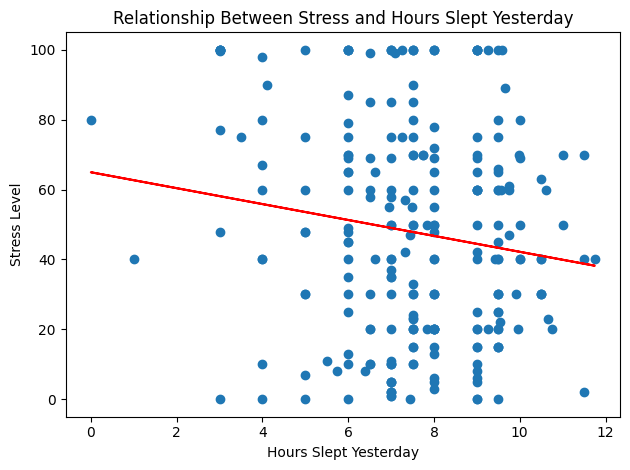

In [20]:
# I will create some plots. Is there a relationship between hours slept last night and stress?
plt.scatter(basic_data_tidy['hours_slept_yesterday'], basic_data_tidy['stress_level'], label='Data Points')

# Calculate a regression line
x = basic_data_tidy['hours_slept_yesterday']
y = basic_data_tidy['stress_level']
m, b = np.polyfit(x, y, 1)

# plot the regression line using that y = mx + b equation
plt.plot(x, m * x + b, color='red')

# add labels and legend
plt.xlabel('Hours Slept Yesterday')
plt.ylabel('Stress Level')
plt.title('Relationship Between Stress and Hours Slept Yesterday')

# this is needed to make the plot look nice when saving it
plt.tight_layout()

# saving this plot for myself
plt.savefig('Plots/stress-hours_slept.png', bbox_inches = 'tight')

# Show the plot
plt.show()

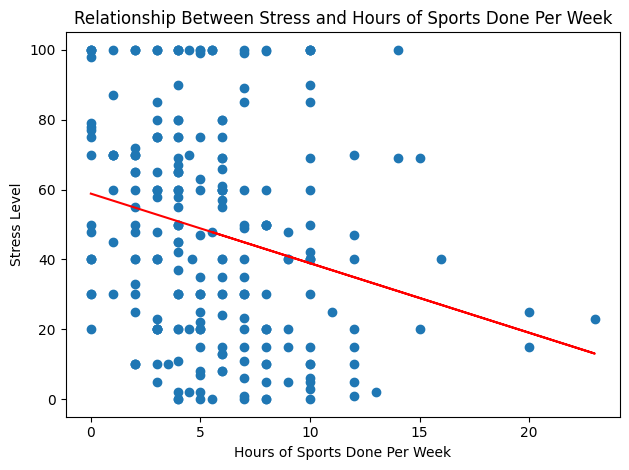

In [21]:
# What about hours of sports and stress?
plt.scatter(basic_data_tidy['sports'], basic_data_tidy['stress_level'], label='Data Points')

# Calculate a regression line
x = basic_data_tidy['sports']
y = basic_data_tidy['stress_level']
m, b = np.polyfit(x, y, 1)

# plot the regression line using that y = mx + b equation
plt.plot(x, m * x + b, color='red')

# add labels and legend
plt.xlabel('Hours of Sports Done Per Week')
plt.ylabel('Stress Level')
plt.title('Relationship Between Stress and Hours of Sports Done Per Week')

# this is needed to make the plot look nice when saving it
plt.tight_layout()

# saving this plot for myself
plt.savefig('Plots/stress-sports.png', bbox_inches = 'tight')

# Show the plot
plt.show()

In [23]:
# The information retrieval column is nearly empty. Values will be imputed using KNN
set(basic_data_tidy['information_retrieval']) # 0, 1, unknown

# the unknown values will be replaced with NaN
basic_data_tidy['information_retrieval'] = basic_data_tidy['information_retrieval'].map(
    lambda x: np.nan if x == 'unknown' else x
)

# table statistics of the column
print(basic_data_tidy['information_retrieval'].value_counts())

# Setting up the KNN
imputer = KNNImputer(n_neighbors=15)

# KNN will be used with the other courses, but those must be cleaned first
set(basic_data_tidy['statistics']) # mu should be 1, sigma which should be 0, and unknown
basic_data_tidy['statistics'] = basic_data_tidy['statistics'].map(
    lambda x: 1 if x == 'mu' else 0 if x == 'sigma' else np.nan
)

# cleaning up the database column
set(basic_data_tidy['databases']) # ja which should be 1, nee which should be 0, and unknown
basic_data_tidy['databases'] = basic_data_tidy['databases'].map(
    lambda x: 1 if x == 'ja' else 0 if x == 'nee' else np.nan
)

# these are the columns that will be used for imputation
features_for_imputation = basic_data_tidy[['information_retrieval', 'machine_learning', 'statistics', 'databases']]

# Perform imputation
imputed_data = imputer.fit_transform(features_for_imputation)

# Check the shape of the imputed data
print("Shape of imputed data:", imputed_data.shape)

# Assign the imputed data back to the appropriate columns
basic_data_tidy[['information_retrieval', 'machine_learning', 'statistics', 'databases']] = imputed_data

# Since decimal values were imputed, they must be rounded to the nearest integer (0 or 1) to make the values binary
basic_data_tidy['information_retrieval'] = np.round(basic_data_tidy['information_retrieval']).astype(int)
basic_data_tidy['machine_learning'] = np.round(basic_data_tidy['machine_learning']).astype(int)
basic_data_tidy['statistics'] = np.round(basic_data_tidy['statistics']).astype(int)
basic_data_tidy['databases'] = np.round(basic_data_tidy['databases']).astype(int)

# print how many 1s and 0s there are
print(basic_data_tidy['information_retrieval'].value_counts())

information_retrieval
0.00    120
1.00    101
Name: count, dtype: int64
Shape of imputed data: (245, 4)
information_retrieval
0.00    125
1.00    101
0.67     10
0.13      3
0.27      2
0.60      2
0.40      1
0.33      1
Name: count, dtype: int64


In [ ]:
# Here are the remaining columns
set(basic_data_tidy['birthday_date']) # some people don't have years...
set(basic_data_tidy['gender']) # so many made up labels...
set(basic_data_tidy['chatgpt_usage']) # no, yes, not willing to say. We all know everyone uses it :)
set(basic_data_tidy['good_day1']) # so many answers
set(basic_data_tidy['good_day2']) # so many answers
